In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
from tensorflow.keras import Sequential
import importlib.util
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D,MaxPool2D,Softmax,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models, callbacks, utils,optimizers


## **HN_Adam**

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import training_ops
from tensorflow.python.util.tf_export import keras_export
from numpy.linalg import norm


# @keras_export('keras.optimizers.HN_Adam')
class HN_Adam(tf.keras.optimizers.Optimizer):


  def __init__(self,
               learning_rate=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-8,
               amsgrad=True,
               lr_multiplier={},
               name='HN_Adam',
               **kwargs):


    super(HN_Adam, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('decay', self._initial_decay)
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or backend_config.epsilon()
    self.amsgrad = amsgrad
    self._lrm_names = list(lr_multiplier.keys())
    for k,v in lr_multiplier.items():
      self._set_hyper(f'lrm_{k}', v)

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')
    for var in var_list:
      self.add_slot(var, 'v')
    if self.amsgrad:
      for var in var_list:
        self.add_slot(var, 'vhat')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(HN_Adam, self)._prepare_local(var_device, var_dtype, apply_state)

    local_step = math_ops.cast(self.iterations + 1, var_dtype)
    beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
    beta_1_power = math_ops.pow(beta_1_t, local_step)
    beta_2_power = math_ops.pow(beta_2_t, local_step)
    lr = (apply_state[(var_device, var_dtype)]['lr_t'] *
          (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
    apply_state[(var_device, var_dtype)].update(dict(
        lr=lr,
        epsilon=ops.convert_to_tensor(self.epsilon, var_dtype),
        beta_1_t=beta_1_t,
        beta_1_power=beta_1_power,
        one_minus_beta_1_t=1 - beta_1_t,
        beta_2_t=beta_2_t,
        beta_2_power=beta_2_power,
        one_minus_beta_2_t=1 - beta_2_t
    ))

  def set_weights(self, weights):
    params = self.weights

    num_vars = int((len(params) - 1) / 2)
    if len(weights) == 3 * num_vars + 1:
      weights = weights[:len(params)]
    super(HN_Adam, self).set_weights(weights)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    v = self.get_slot(var, 'v')

    lr_t = coefficients['lr_t']
    for k in self._lrm_names:
      if var.name.startswith(k):
        lr_t = coefficients['lr_t'] * self._get_hyper(f'lrm_{k}', var.dtype)


    if not self.amsgrad:
      return training_ops.resource_apply_adam(
          var.handle,
          m.handle,
          v.handle,
          coefficients['beta_1_power'],
          coefficients['beta_2_power'],
          lr_t,
          coefficients['beta_1_t'],
          coefficients['beta_2_t'],
          coefficients['epsilon'],
          grad,
          use_locking=self._use_locking)
    else:
      vhat = self.get_slot(var, 'vhat')
      return training_ops.resource_apply_adam_with_amsgrad(
          var.handle,
          m.handle,
          v.handle,
          vhat.handle,
          coefficients['beta_1_power'],
          coefficients['beta_2_power'],
          lr_t,
          coefficients['beta_1_t'],
          coefficients['beta_2_t'],
          coefficients['epsilon'],
          grad,
          use_locking=self._use_locking)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))


    # m_t = beta1 * m + (1 - beta1) * g_t
    m = self.get_slot(var, 'm')
    m_scaled_g_values = abs(grad) * coefficients['one_minus_beta_1_t']
    m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                           use_locking=self._use_locking)
    with ops.control_dependencies([m_t]):
      m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

      At0 = random.uniform(1, 4)
      m_t_max =  math_ops.maximum(m_t , abs(grad))
      At = At0 - (m_t /m_t_max)
      if At < 2:
        amsgrad=True
      else:
        amsgrad=False

    # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
    v = self.get_slot(var, 'v')
    v_scaled_g_values = (grad^At)  * coefficients['one_minus_beta_2_t']
    v_t = state_ops.assign(v, v * coefficients['beta_2_t'],
                           use_locking=self._use_locking)
    with ops.control_dependencies([v_t]):
      v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

    lr = coefficients['lr']
    for k in self._lrm_names:
      if var.name.startswith(k):
        lr = coefficients['lr'] * self._get_hyper(f'lrm_{k}', var.dtype)

    if not self.amsgrad:
      v_sqrt = math_ops.sqrt(v_t)
      var_update = state_ops.assign_sub(
          var, lr * m_t / ((norm(v_t,At))+ coefficients['epsilon']),
          use_locking=self._use_locking)
      return control_flow_ops.group(*[var_update, m_t, v_t])
    else:
      v_hat = self.get_slot(var, 'vhat')
      v_hat_t = math_ops.maximum(v_hat, v_t)
      with ops.control_dependencies([v_hat_t]):
        v_hat_t = state_ops.assign(
            v_hat, v_hat_t, use_locking=self._use_locking)
        v_hat_sqrt = math_ops.sqrt(v_hat_t)

      var_update = state_ops.assign_sub(
          var,
          lr * m_t / ((norm(v_hat_t,At)) + coefficients['epsilon']),
          use_locking=self._use_locking)
      return control_flow_ops.group(*[var_update, m_t, v_t, v_hat_t])

  def get_config(self):
    config = super(HN_Adam, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'decay': self._serialize_hyperparameter('decay'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'epsilon': self.epsilon,
        'amsgrad': self.amsgrad,
    })
    for k in self._lrm_names:
      config[k] = self._serialize_hyperparameter(f'lrm_{k}')
    return config

In [21]:
def to_float32(img):
    return img.astype(np.float32)
trainD=ImageDataGenerator(
rescale=1./255,rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    preprocessing_function=to_float32,
    fill_mode='nearest')        # Fill edges with reflection (better than black))
df_train = trainD.flow_from_directory(
    r"mnist_images\train",
    target_size=(28, 28),
    color_mode="grayscale",      # MNIST is single-channel
    batch_size=32,
    class_mode="sparse"          # <-- not the loss name
)

Found 40000 images belonging to 10 classes.


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def to_float32(img):
    return img.astype('float32')

testD = ImageDataGenerator(
    rescale=1.0/255.0,
    preprocessing_function=to_float32
)

df_test = testD.flow_from_directory(
    r"mnist_images\test",
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=32,
    class_mode="sparse",
    shuffle=False  # typically you don't shuffle test data
)

valD = ImageDataGenerator(
    rescale=1.0/255.0,
    preprocessing_function=to_float32
)

df_val = valD.flow_from_directory(
    r"mnist_images\val",
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)


Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [23]:

def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))

    return model

create_model().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                 

In [ ]:
from tensorflow_addons.optimizers import AdaBelief
import pickle  
import tensorflow as tf
from tensorflow_addons.optimizers import AdaBelief
from tensorflow.keras.callbacks import EarlyStopping
import pickle

# 1. Learning rates
learning_rates = {
    'HN_Adam': 1e-3,  # Base LR before scheduler
    'Adam_AMSGrad': 5e-4,
    'AdaBelief': 1e-3,
    'Adam': 1e-4,
    'SGD': 1e-2,
    'RMSprop': 1e-3,
    'Adagrad': 1e-2
}

hnadam_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

optimizers_dict = {
    'HN_Adam': lambda: HN_Adam(learning_rate=hnadam_lr_schedule),
    'Adam_AMSGrad': lambda: tf.keras.optimizers.Adam(learning_rate=learning_rates['Adam_AMSGrad'], amsgrad=True),
    'AdaBelief': lambda: AdaBelief(learning_rate=learning_rates['AdaBelief']),
    'Adam': lambda: tf.keras.optimizers.Adam(learning_rate=learning_rates['Adam']),
    'SGD': lambda: tf.keras.optimizers.SGD(learning_rate=learning_rates['SGD'], momentum=0.9),
    'RMSprop': lambda: tf.keras.optimizers.RMSprop(learning_rate=learning_rates['RMSprop']),
    'Adagrad': lambda: tf.keras.optimizers.Adagrad(learning_rate=learning_rates['Adagrad']),
}


histories = {}

for name, opt_fn in optimizers_dict.items():
    print(f"\nTraining with {name}…")
    
    model = create_model()
    model.compile(
        optimizer=opt_fn(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    hist = model.fit(
        df_train,
        epochs=100,
        batch_size=32,
        validation_data=df_val,
        verbose=1
    )
    
    # Save history in dictionary and also to file
    histories[name] = hist.history
    
    with open(f'history_{name}.pkl', 'wb') as f:
        pickle.dump(hist.history, f)

    # Save model
    model.save(f"model_{name}.h5")



Training with HN_Adam…
Epoch 1/100
1250/1250 [==============================] - 72s 57ms/step - loss: 0.3189 - accuracy: 0.9008 - val_loss: 0.0631 - val_accuracy: 0.9840
Epoch 2/100
1250/1250 [==============================] - 64s 51ms/step - loss: 0.0959 - accuracy: 0.9732 - val_loss: 0.0523 - val_accuracy: 0.9866
Epoch 3/100
1250/1250 [==============================] - 57s 46ms/step - loss: 0.0664 - accuracy: 0.9816 - val_loss: 0.0377 - val_accuracy: 0.9891
Epoch 4/100
1250/1250 [==============================] - 57s 45ms/step - loss: 0.0499 - accuracy: 0.9855 - val_loss: 0.0395 - val_accuracy: 0.9897
Epoch 5/100
1250/1250 [==============================] - 57s 46ms/step - loss: 0.0418 - accuracy: 0.9876 - val_loss: 0.0340 - val_accuracy: 0.9914
Epoch 6/100
1250/1250 [==============================] - 57s 46ms/step - loss: 0.0354 - accuracy: 0.9900 - val_loss: 0.0287 - val_accuracy: 0.9919
Epoch 7/100
1250/1250 [==============================] - 58s 46ms/step - loss: 0.0306 - accura

In [10]:
from tensorflow_addons.optimizers import AdaBelief
import pickle  
import tensorflow as tf
from tensorflow_addons.optimizers import AdaBelief
from tensorflow.keras.callbacks import EarlyStopping
import pickle

# 1. Learning rates
learning_rates = {
    'Adagrad': 1e-2
}

hnadam_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)

optimizers_dict = {

    'Adagrad': lambda: tf.keras.optimizers.Adagrad(learning_rate=learning_rates['Adagrad']),
}


histories = {}

for name, opt_fn in optimizers_dict.items():
    print(f"\nTraining with {name}…")
    
    model = create_model()
    model.compile(
        optimizer=opt_fn(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    hist = model.fit(
        df_train,
        epochs=100,
        batch_size=32,
        validation_data=df_val,
        verbose=1
    )
    
    # Save history in dictionary and also to file
    histories[name] = hist.history
    
    with open(f'history_{name}.pkl', 'wb') as f:
        pickle.dump(hist.history, f)

    # Save model
    model.save(f"model_{name}.h5")



Training with Adagrad…
Epoch 1/100
1250/1250 [==============================] - 69s 54ms/step - loss: 0.8726 - accuracy: 0.7072 - val_loss: 0.1572 - val_accuracy: 0.9523
Epoch 2/100
1250/1250 [==============================] - 61s 49ms/step - loss: 0.1984 - accuracy: 0.9407 - val_loss: 0.0945 - val_accuracy: 0.9709
Epoch 3/100
1250/1250 [==============================] - 55s 44ms/step - loss: 0.1354 - accuracy: 0.9600 - val_loss: 0.0637 - val_accuracy: 0.9808
Epoch 4/100
1250/1250 [==============================] - 55s 44ms/step - loss: 0.1098 - accuracy: 0.9672 - val_loss: 0.0660 - val_accuracy: 0.9801
Epoch 5/100
1250/1250 [==============================] - 55s 44ms/step - loss: 0.0945 - accuracy: 0.9721 - val_loss: 0.0552 - val_accuracy: 0.9843
Epoch 6/100
1250/1250 [==============================] - 55s 44ms/step - loss: 0.0838 - accuracy: 0.9760 - val_loss: 0.0653 - val_accuracy: 0.9807
Epoch 7/100
1250/1250 [==============================] - 55s 44ms/step - loss: 0.0758 - accura

In [12]:
from tensorflow.keras.models import load_model

model_paths = {
    'HN_Adam': 'model_HN_Adam.h5',
    'AdaBelief': 'model_AdaBelief.h5',
    'Adam': 'model_Adam.h5',
    'Adam_AMSGrad': 'model_Adam_AMSGrad.h5',
    'SGD': 'model_SGD.h5',
    'RMSprop': 'model_RMSprop.h5',
    'Adagrad': 'model_Adagrad.h5',
}

test_accuracies = {}

for name, model_path in model_paths.items():
    print(f"\nLoading and evaluating {name} model...")

    if name == 'HN_Adam':
        model = load_model(model_path, custom_objects={'HN_Adam': HN_Adam})
    else:
        model = load_model(model_path)

    # Evaluate on the test data
    loss, acc = model.evaluate(df_test, verbose=0)
    test_accuracies[name] = acc
    print(f"✅ {name} Test Accuracy: {acc:.4f}")



Loading and evaluating HN_Adam model...
✅ HN_Adam Test Accuracy: 0.9958

Loading and evaluating AdaBelief model...
✅ AdaBelief Test Accuracy: 0.9930

Loading and evaluating Adam model...
✅ Adam Test Accuracy: 0.9953

Loading and evaluating Adam_AMSGrad model...
✅ Adam_AMSGrad Test Accuracy: 0.9957

Loading and evaluating SGD model...
✅ SGD Test Accuracy: 0.9941

Loading and evaluating RMSprop model...
✅ RMSprop Test Accuracy: 0.1135

Loading and evaluating Adagrad model...
✅ Adagrad Test Accuracy: 0.9946


In [24]:
from tensorflow.keras.optimizers import RMSprop

model = create_model()   

model.load_weights('model_RMSprop.h5')

model.compile(
    optimizer=RMSprop(),                                
    loss='sparse_categorical_crossentropy',           
    metrics=['accuracy']                               
)
loss, acc = model.evaluate(df_test, verbose=0)
print(f"RMSprop test accuracy = {acc:.4f}")


RMSprop test accuracy = 0.9944


## **plotting Evaluations**

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_paths = [
    "history_AdaBelief.pkl",
    "history_Adagrad.pkl",
    "history_Adam.pkl",
    "history_Adam_AMSGrad.pkl",
    "history_HN_Adam.pkl",
    "history_RMSprop.pkl",     
    "history_SGD.pkl"
]

histories = {}
for file in file_paths:
    with open(file, 'rb') as f:
        model_name = os.path.splitext(file)[0].replace("history_", "")
        histories[model_name] = pickle.load(f)

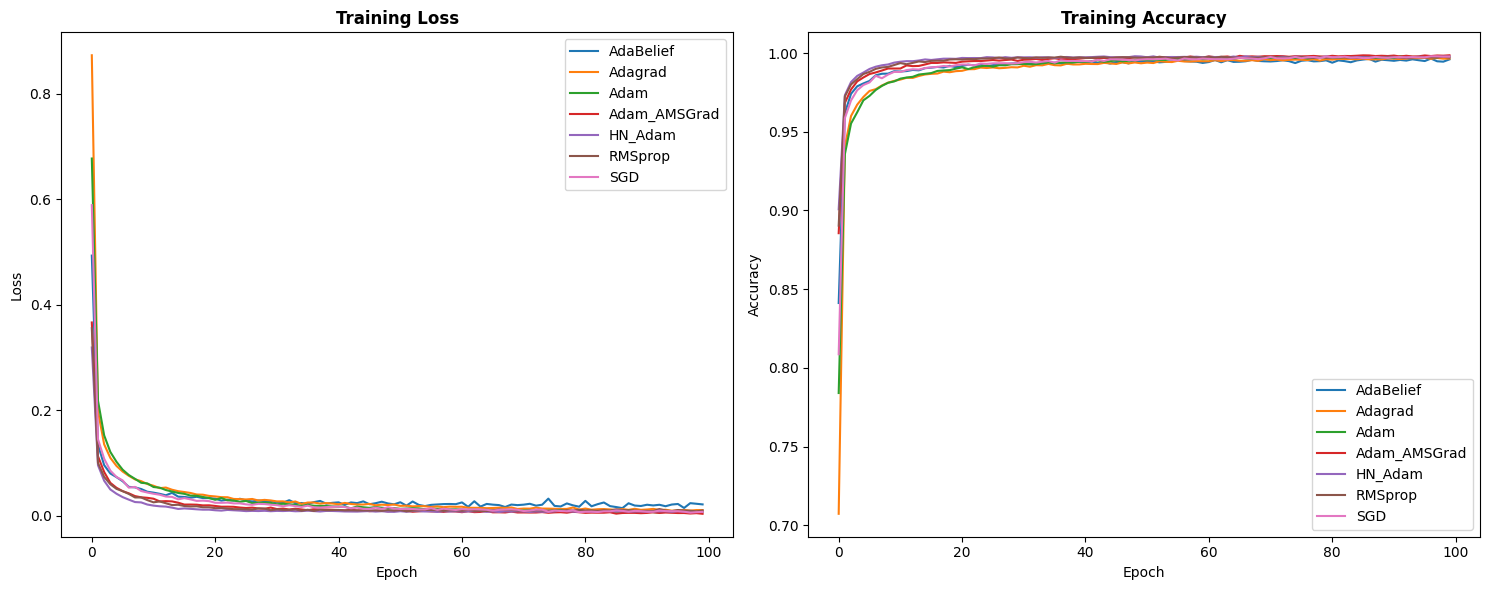

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
 

plt.subplot(1, 2, 1)
for model, history in histories.items():
    plt.plot(history['loss'], label=model)
plt.title('Training Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend()

# Training Accuracy
plt.subplot(1, 2, 2)
for model, history in histories.items():
    plt.plot(history['accuracy'], label=model)
plt.title('Training Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()

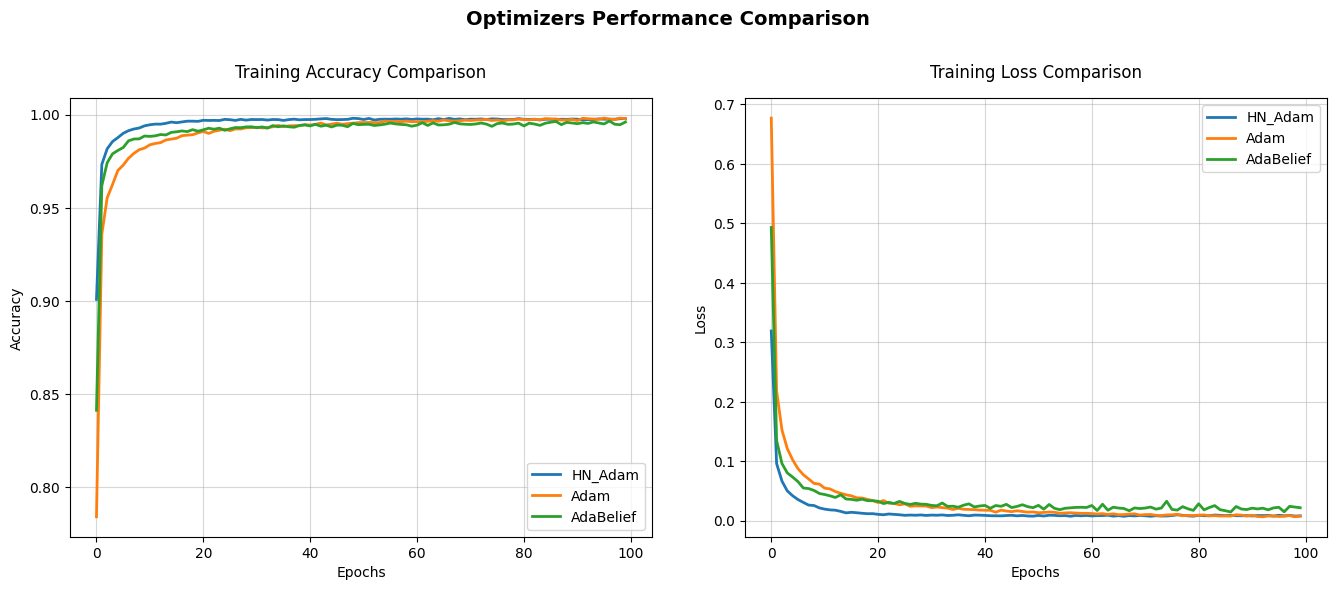

In [5]:
import matplotlib.pyplot as plt


selected_optimizers = ['HN_Adam', 'Adam', 'AdaBelief']


plt.figure(figsize=(14, 6))   



plt.subplot(1, 2, 1)
for name in selected_optimizers:
    plt.plot(
        histories[name]['accuracy'], 
        label=name,  
        linewidth=2
    )
plt.title('Training Accuracy Comparison', fontsize=12, pad=15)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend(loc='lower right', frameon=True)   
plt.grid(True, alpha=0.5)


plt.subplot(1, 2, 2)
for name in selected_optimizers:
    plt.plot(
        histories[name]['loss'], 
        label=name,
        linewidth=2
    )
plt.title('Training Loss Comparison', fontsize=12, pad=15)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc='upper right', frameon=True)
plt.grid(True, alpha=0.5)

 
plt.tight_layout(pad=3)  
plt.suptitle('Optimizers Performance Comparison', y=1.02, fontsize=14, fontweight='bold')
plt.show()

In [8]:
print("\nBest Training Results:")
for name in histories:
    best_train_acc = max(histories[name]['accuracy']) 
    best_train_loss = min(histories[name]['loss'])    
    print(f"{name} — Best Train Accuracy: {best_train_acc:.4f}, Best Train Loss: {best_train_loss:.4f}")


Best Training Results:
AdaBelief — Best Train Accuracy: 0.9966, Best Train Loss: 0.0145
Adagrad — Best Train Accuracy: 0.9971, Best Train Loss: 0.0097
Adam — Best Train Accuracy: 0.9981, Best Train Loss: 0.0064
Adam_AMSGrad — Best Train Accuracy: 0.9987, Best Train Loss: 0.0038
HN_Adam — Best Train Accuracy: 0.9980, Best Train Loss: 0.0072
RMSprop — Best Train Accuracy: 0.9977, Best Train Loss: 0.0084
SGD — Best Train Accuracy: 0.9980, Best Train Loss: 0.0060


In [9]:
print("\nBest Training Results:")
for name in histories:
    best_train_loss = min(histories[name]['val_loss'])    
    print(f"{name}  Best Train val_loss: {best_train_loss:.4f}")


Best Training Results:
AdaBelief  Best Train val_loss: 0.0312
Adagrad  Best Train val_loss: 0.0316
Adam  Best Train val_loss: 0.0255
Adam_AMSGrad  Best Train val_loss: 0.0241
HN_Adam  Best Train val_loss: 0.0236
RMSprop  Best Train val_loss: 0.0264
SGD  Best Train val_loss: 0.0261
